In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/sample_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')

## Issue 1

### Process data: normalize features, delete outliers, etc.

#### $^{*}$ Read about WoE & make this processing for any feature

In [3]:
#Let's take a look on our data
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29996,72228,Female,48.0,1,0,No,Govt_job,Rural,119.19,34.3,never smoked,0
29997,14747,Male,72.0,0,0,Yes,Self-employed,Urban,86.83,34.8,NaN,0
29998,50636,Female,20.0,0,0,No,Private,Rural,67.76,19.7,never smoked,0
29999,43161,Female,27.0,0,0,No,Private,Urban,82.65,22.5,never smoked,0


## 1.1. WoE and IV

### First of all, I would like to try this WoE and IV thing because it can make our job easier and define valuable features.

### As a feature I chose age because it should be easy :)

In [4]:
WoE_table = train[['age','stroke']]

#I'd like to sort this table by age
WoE_table = WoE_table.sort_values('age')

#First step - we should split our data in ~10 categories
a_max = WoE_table['age'].values[-1]
a_min = WoE_table['age'].values[1]
print('min age is',a_min)
print('max age is',a_max)

#what? 0.08? what does it mean? okay, let's pretend that it's okay
group_name = []
events = []
non_events = []
for i in range(1,9):
    if i==1:
        part = WoE_table[(WoE_table['age']>=0) & (WoE_table['age']<=10)]
        group = '0 - 10'

    elif i==8:
        part = WoE_table[(WoE_table['age']>=71) & (WoE_table['age']<=82)]
        group = '71 - 82'
    else:
        part = WoE_table[(WoE_table['age']>=((i-1)*10+1)) & (WoE_table['age']<=((i)*10))]
        group = str(((i-1)*10+1)) + ' - ' + str((i)*10)
        
    event = part['stroke'].sum()
    non_event = len(part['stroke'].values) - event
    
    group_name.append(group)
    events.append(event)
    non_events.append(non_event)

#We've processed data and receive 8 age groups    
IV_table = pd.DataFrame({'Age Group':group_name, 'Have stroke': events, "Haven't stroke": non_events})
print(IV_table)

min age is 0.08
max age is 82.0
  Age Group  Have stroke  Haven't stroke
0    0 - 10            1            3119
1   11 - 20            1            3008
2   21 - 30            1            3666
3   31 - 40           14            3882
4   41 - 50           38            4362
5   51 - 60           90            4585
6   61 - 70          117            3442
7   71 - 82          268            3407


In [5]:
#Let's calculate WoE for each of groups

#first of all, we should define '% Have stroke',"% Haven't stroke"
def get_percentage(row,column,summ):
    return (row[column]/summ)*100

IV_table['% Have stroke']=IV_table.apply(get_percentage,args=['Have stroke',IV_table['Have stroke'].sum()],axis=1)
IV_table["% Haven't stroke"]=IV_table.apply(get_percentage,args=["Haven't stroke",IV_table["Haven't stroke"].sum()],axis=1)

#now we are ready to calculate WoE
import math
def WoE(row):
    return math.log(row["% Haven't stroke"]/row['% Have stroke'])
IV_table['WoE'] = IV_table.apply(WoE,axis=1)

#Final step is to calculate IV for each group and summerize it
def IV(row):
    return (row["% Haven't stroke"] - row['% Have stroke']) * row['WoE']
IV_table['IV'] = IV_table.apply(IV,axis=1)
print('Total IV for age is', (IV_table['IV'].sum()).round(2))

#Let's take a look at result.
IV_table

Total IV for age is 219.91


,Age Group,Have stroke,Haven't stroke,% Have stroke,% Haven't stroke,WoE,IV
0,0 - 10,1,3119,0.188679,10.583285,4.026983,41.858899
1,11 - 20,1,3008,0.188679,10.206644,3.990746,39.979149
2,21 - 30,1,3666,0.188679,12.439347,4.188571,51.312798
3,31 - 40,14,3882,2.641509,13.172271,1.606763,16.920443
4,41 - 50,38,4362,7.169811,14.800991,0.724815,5.531192
5,51 - 60,90,4585,16.981132,15.557667,-0.087549,0.124623
6,61 - 70,117,3442,22.075472,11.679278,-0.636651,6.618747
7,71 - 82,268,3407,50.566038,11.560517,-1.475685,57.559845


#### So, what can we say according to IV of 'age' feature? Its predictive power is 'suspicious or too good to be true'. I think it's quite obvious that such groups as children and very old people contribute the most in WoE and therefore in IV according to formulae.

## 1.2. Data processing

In [6]:
#Let's remember how our data look like
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29996,72228,Female,48.0,1,0,No,Govt_job,Rural,119.19,34.3,never smoked,0
29997,14747,Male,72.0,0,0,Yes,Self-employed,Urban,86.83,34.8,NaN,0
29998,50636,Female,20.0,0,0,No,Private,Rural,67.76,19.7,never smoked,0
29999,43161,Female,27.0,0,0,No,Private,Urban,82.65,22.5,never smoked,0


In [7]:
#Okay, we've got 10 features
#let's look closely to each one

##1-gender

train['gender'].value_counts()
#we've got three types, let's substitute them with numbers
train['gender'].replace( {'Female': 1, 'Male': 0, 'Other': -1} ,inplace = True)


##I think hypertension, heart disease data is okay, let it be this way

In [8]:
##2-ever_married

train['ever_married'].value_counts()
#As I can see we haven't any nans here,so I will just substitute strings with numbers
train['ever_married'].replace( {'Yes': 1, 'No': 0} ,inplace = True)


In [9]:
##3-work_type

train['work_type'].value_counts()
#let's try something new for this
train['work_type'].replace( dict(train['work_type'].value_counts(1)),inplace = True)

In [10]:
##4-Residence_type
train['Residence_type'].value_counts()
train['Residence_type'].replace( {'Rural': 1, 'Urban': 0} ,inplace = True)
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,0,3.0,0,0,0,0.139595,1,95.12,18.0,NaN,0
1,30468,0,58.0,1,0,1,0.573981,0,87.96,39.2,never smoked,0
2,16523,1,8.0,0,0,0,0.573981,0,110.89,17.6,NaN,0
3,56543,1,70.0,0,0,1,0.573981,1,69.04,35.9,formerly smoked,0
4,46136,0,14.0,0,0,0,0.003833,1,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29996,72228,1,48.0,1,0,0,0.126796,1,119.19,34.3,never smoked,0
29997,14747,0,72.0,0,0,1,0.155795,0,86.83,34.8,NaN,0
29998,50636,1,20.0,0,0,0,0.573981,1,67.76,19.7,never smoked,0
29999,43161,1,27.0,0,0,0,0.573981,0,82.65,22.5,never smoked,0


In [11]:
##5-bmi(body mass index)
#let's just normalize it
_min = min(train['bmi'].values)
_max = max(train['bmi'].values)
train['bmi'] = (train['bmi'] - _min)/(_max - _min)
bmi_mean = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(bmi_mean)

In [12]:
##6-avg_glucose_level
_min = min(train['avg_glucose_level'].values)
_max = max(train['avg_glucose_level'].values)
train['avg_glucose_level'] = (train['avg_glucose_level'] - _min)/(_max - _min)
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,0,3.0,0,0,0,0.139595,1,0.177060,0.090286,NaN,0
1,30468,0,58.0,1,0,1,0.573981,0,0.145461,0.332571,never smoked,0
2,16523,1,8.0,0,0,0,0.573981,0,0.246657,0.085714,NaN,0
3,56543,1,70.0,0,0,1,0.573981,1,0.061962,0.294857,formerly smoked,0
4,46136,0,14.0,0,0,0,0.003833,1,0.469041,0.102857,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29996,72228,1,48.0,1,0,0,0.126796,1,0.283287,0.276571,never smoked,0
29997,14747,0,72.0,0,0,1,0.155795,0,0.140474,0.282286,NaN,0
29998,50636,1,20.0,0,0,0,0.573981,1,0.056313,0.109714,never smoked,0
29999,43161,1,27.0,0,0,0,0.573981,0,0.122027,0.141714,never smoked,0


In [13]:
##7-smoking_status
train['smoking_status'].value_counts()
train['smoking_status'].replace( {'never smoked': 1, 'formerly smoked': 0, 'smokes': -1} ,inplace = True)
train['smoking_status'] = train['smoking_status'].fillna(0)

In [14]:
##8-age
#let's substitute it with WoE
def age_to_WoE(row,IV_table):
    if row['age']%10 !=0:
        group = (row['age']//10)
#         return IV_table['WoE'][group]    
    else:
        group = (row['age']//10) - 1    
    if group==8:
        group = group - 1
    return IV_table['WoE'][group]
train['age']=train.apply(age_to_WoE,args=[IV_table],axis=1)

In [15]:
#Let's do the same things with test dataset
test['gender'].replace( {'Female': 1, 'Male': 0, 'Other': -1} ,inplace = True)

test['ever_married'].replace( {'Yes': 1, 'No': 0} ,inplace = True)

test['work_type'].replace( dict(test['work_type'].value_counts(1)),inplace = True)

test['Residence_type'].replace( {'Rural': 1, 'Urban': 0} ,inplace = True)

_min = min(test['bmi'].values)
_max = max(test['bmi'].values)
test['bmi'] = (test['bmi'] - _min)/(_max - _min)
bmi_mean = test['bmi'].mean()
test['bmi'] = test['bmi'].fillna(bmi_mean)

_min = min(test['avg_glucose_level'].values)
_max = max(test['avg_glucose_level'].values)
test['avg_glucose_level'] = (test['avg_glucose_level'] - _min)/(_max - _min)

test['smoking_status'].replace( {'never smoked': 1, 'formerly smoked': 0, 'smokes': -1} ,inplace = True)
test['smoking_status'] = test['smoking_status'].fillna(0)

test['age']=test.apply(age_to_WoE,args=[IV_table],axis=1)

## Issue 2

### Q: Make feature selection using common sense. Why you select these features?

### A: I'd like to choose such features as: work type, bmi, smoking status, hypertension and age. I make this choice because, in my view, work type, bmi, age and smoking status define the health status of a person. Hypertension is a serious disease which is connected with cardiovascular system. 



## Issue 3

###  For each of 3 algorithms (logistic regression, decision tree, and random forest) select 3 hyperparameters:
    1) For each of the selected hyperparameters choose 5 values, fix other parameters, and make cross-validation. 
    2) Plot mean CV score from hyperparameter value
    3) Comment

### 1. Logistic regresson

#### For hyperparameters I chose tol (tolerance for stopping criteria), max_iter (Maximum number of iterations taken for the solvers to converge), solver (Algorithm to use in the optimization problem).

### 1.1.Hyperparameter - tol

In [42]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

features_list = ['work_type','bmi','smoking_status','hypertension','age']
target_name = 'stroke'

In [43]:
def cross_validation_LR(train, test, features_list, target_name, tol_value, max_iter_value, solver_name):
    kf = KFold (n_splits = 5)
    kf.get_n_splits(train)
    
    auc_list=[]

    i= 0   
    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features_list], train.loc[test_index, features_list]
        y_train, y_test = train.loc[train_index, target_name], train.loc[test_index, target_name]

        model = LogisticRegression(tol=tol_value, max_iter=max_iter_value, solver=solver_name)

        model.fit(X_train, y_train)

        test_pred = model.predict_proba(X_test)[:,1]

        auc = roc_auc_score(y_score=test_pred, y_true = y_test )
        auc_list.append(auc)
    
    print("Mean auc for 5-fold: {}".format(str(np.mean(auc_list))))

    return np.mean(auc_list)

In [44]:
tols = [0.0001, 10, 1000, 10000, 1000000]
max_iter = 100
solver = 'lbfgs'
auc_array_tols = []
for elem in tols:
    auc = cross_validation_LR(train, test, features_list, target_name, elem, max_iter, solver)
    auc_array_tols.append(auc)

Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8321930147697953
Mean auc for 5-fold: 0.8151371604501015
Mean auc for 5-fold: 0.8263089309082275
Mean auc for 5-fold: 0.5


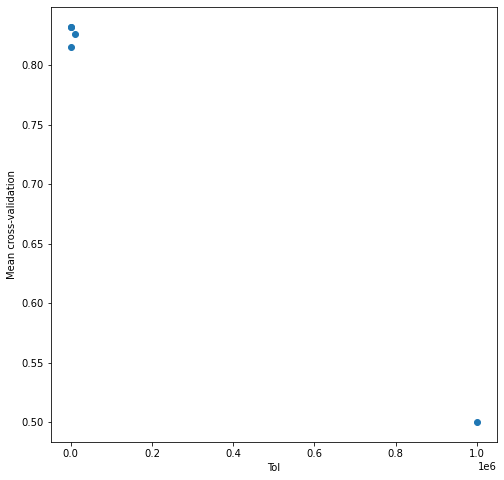

In [45]:
plt.figure(figsize= (8,8))
plt.scatter( tols, auc_array_tols)
plt.xlabel('Tol')
plt.ylabel('Mean cross-validation')
plt.show()

### This way, we can see that tolerance influences result of prediction: If it begins to grow, the result starts to get worse. Why is it so? Tolerance is stopping criteria so it tells algorithm to stop looking for minimum when some value of tolerance is achieved. Therefore, if tol is big, algorithm can stop searching when it's far from actual minimum.  

### 1.2. Hyperparameter - max_ter 

In [46]:
tol = 0.0001
max_iter = [100, 1000, 50, 30, 5]
solver = 'lbfgs'
auc_array_max_iter = []
for elem in max_iter:
    auc = cross_validation_LR(train, test, features_list, target_name, tol, elem, solver)
    auc_array_max_iter.append(auc)

Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8142732243138567


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


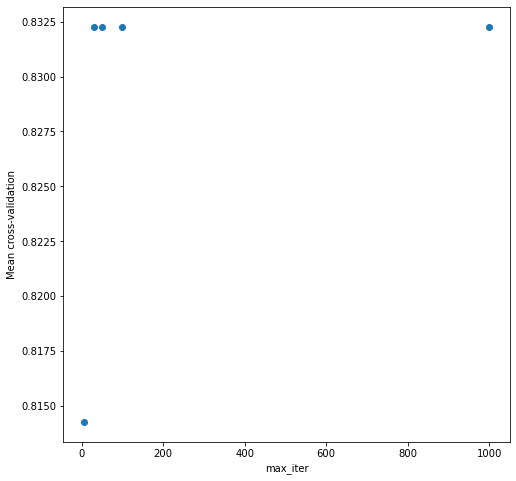

In [47]:
plt.figure(figsize= (8,8))
plt.scatter( max_iter, auc_array_max_iter)
plt.xlabel('max_iter')
plt.ylabel('Mean cross-validation')
plt.show()

### This way, we can see that number of iterations doesn't affect much prediction results of our data. However, we can see that small number of iterations crushes the algorithm. So, we should be careful about it.

### 1.3.Hyperparameter-solver

In [48]:
tol = 0.0001
max_iter = 100
solvers = ['lbfgs','newton-cg', 'liblinear', 'sag', 'saga']
auc_array_solvers = []
for elem in solvers:
    auc = cross_validation_LR(train, test, features_list, target_name, tol, max_iter, elem)
    auc_array_solvers.append(auc)

Mean auc for 5-fold: 0.8322625101109559
Mean auc for 5-fold: 0.8322622506208515
Mean auc for 5-fold: 0.8319777997433466
Mean auc for 5-fold: 0.8322632470948662
Mean auc for 5-fold: 0.8322605391653954


0 - 'lbfgs',1 - 'newton-cg',2 - liblinear',3 - 'sag',4 - 'saga' 


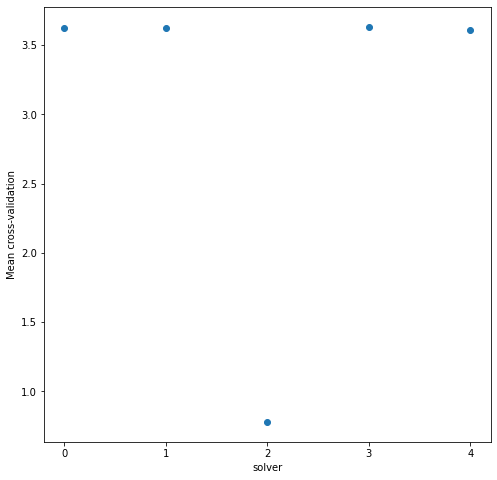

In [70]:
y = np.array(auc_array_solvers)
y = (y-0.8319)*10000
print("0 - 'lbfgs',1 - 'newton-cg',2 - liblinear',3 - 'sag',4 - 'saga' ")
plt.figure(figsize= (8,8))
plt.scatter( np.arange(5), y)
plt.xlabel('solver')
plt.ylabel('Mean cross-validation')
# plt.xticks(solvers)
plt.xticks(np.arange(5))
plt.show()

### As we can see all solvers give nearly the same result. We can see some differences only in the third sign after comma. The best result is received by lbfgs solver.

### 2. Decision tree

#### For hyperparameters I chose max_depth, min_samples_split (the minimum number of samples required to split an internal node), min_samples_leaf (the minimum number of samples required to be at a leaf node). 

### 2.1. Hyperparameter - max_depth

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
def cross_validation_DT(train, test, features_list, target_name, max_depth_value, min_samples_split_value, min_samples_leaf_value):
    kf = KFold (n_splits = 5)
    kf.get_n_splits(train)

    auc_list = []

    i= 0   
    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features_list], train.loc[test_index, features_list]
        y_train, y_test = train.loc[train_index, target_name], train.loc[test_index, target_name]

        model = DecisionTreeClassifier( max_depth = max_depth_value, min_samples_split = min_samples_split_value, min_samples_leaf = min_samples_leaf_value)

        model.fit(X_train, y_train)

        test_pred = model.predict_proba(X_test)[:,1]

        auc = roc_auc_score(y_score=test_pred, y_true = y_test )
        auc_list.append(auc)

    print("Mean auc for 5-fold: {}".format(str(np.mean(auc_list))))

    return np.mean(auc_list)

In [52]:
#Before I change max_depth of tree, I would like to see what depth of tree can be in our case
model = DecisionTreeClassifier()

model.fit(train[['work_type','bmi','smoking_status','hypertension','age']], train['stroke'])
print(model.get_depth())

26


In [53]:
max_depth_value = [26,50,1000, 2, 1]
min_samples_split_value = 2
min_samples_leaf_value = 1
auc_array_max_depth = []
for elem in max_depth_value:
    auc = cross_validation_DT(train, test, features_list, target_name, elem, min_samples_split_value, min_samples_leaf_value)
    auc_array_max_depth.append(auc)

Mean auc for 5-fold: 0.5833231425855938
Mean auc for 5-fold: 0.5825659921586113
Mean auc for 5-fold: 0.5845915485168101
Mean auc for 5-fold: 0.8011800369656639
Mean auc for 5-fold: 0.6956659145908659


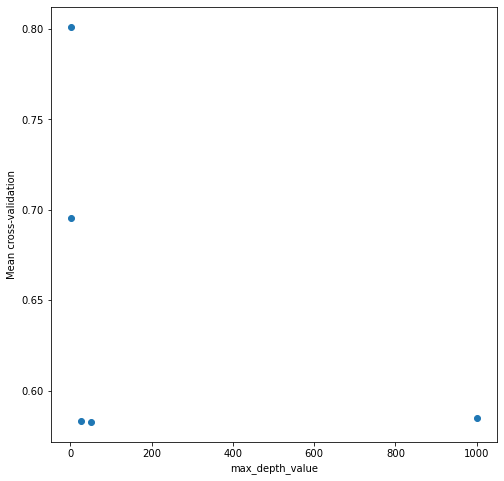

In [55]:
plt.figure(figsize= (8,8))
plt.scatter( max_depth_value, auc_array_max_depth)
plt.xlabel('max_depth_value')
plt.ylabel('Mean cross-validation')
plt.show()

### As we can see max_depth is a very important hyperparameter. When it wasn't fixed, our rmse wasn't optimal. When we fixed max_depth = 2, we got a better score. I think that the reason is that we got some parameter that mainly define whether person got stroke or not. I suppose that it is age.

### 2.2. Hyperparameter - min_samples_split[](http://)

In [56]:
max_depth_value = 26
min_samples_split_value = [2, 10, 100, 1000, 5000]
min_samples_leaf_value = 1
auc_array_min_samples_split = []
for elem in min_samples_split_value:
    auc = cross_validation_DT(train, test, features_list, target_name, max_depth_value, elem, min_samples_leaf_value)
    auc_array_min_samples_split.append(auc)

Mean auc for 5-fold: 0.5833614537714115
Mean auc for 5-fold: 0.6071505525850134
Mean auc for 5-fold: 0.7131225148842206
Mean auc for 5-fold: 0.8229616778603581
Mean auc for 5-fold: 0.8256146078324008


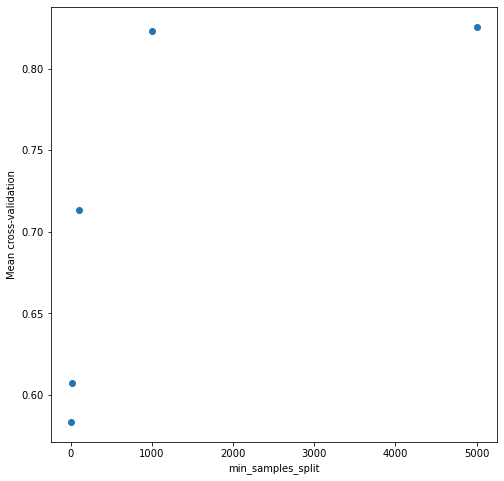

In [57]:
plt.figure(figsize= (8,8))
plt.scatter( min_samples_split_value, auc_array_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('Mean cross-validation')
plt.show()

### In this case, increasing of min_samples_split number results in increasing mean CV score. I think it is connected with previous case, the larger min_samples_split number the smaller max_depth we can get.

### 2.3.Hyperparameter-min_samples_leaf

In [58]:
max_depth_value = 26
min_samples_split_value = 2
min_samples_leaf_value = [1, 10, 100, 1000, 10000]
auc_array_min_samples_leaf = []
for elem in min_samples_leaf_value:
    auc = cross_validation_DT(train, test, features_list, target_name, max_depth_value, min_samples_split_value, elem)
    auc_array_min_samples_leaf.append(auc)

Mean auc for 5-fold: 0.583284349693313
Mean auc for 5-fold: 0.6479135148940675
Mean auc for 5-fold: 0.7852326322920196
Mean auc for 5-fold: 0.8273192326311316
Mean auc for 5-fold: 0.7160183087050592


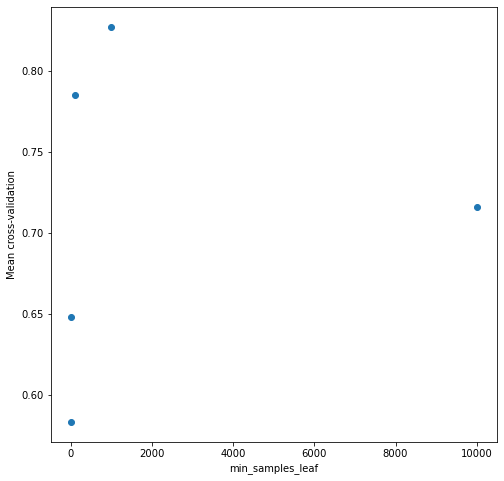

In [59]:
plt.figure(figsize= (8,8))
plt.scatter( min_samples_leaf_value, auc_array_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean cross-validation')
plt.show()

### In this case, increasing of min_samples_leaf number results in increasing mean CV score but at point 10000 mean CV score starts to fall again, so we got optimal value somewhere between 1000 and 10000.

### 3. Random forest

#### For hyperparameters I chose n_estimators (the number of trees in the forest), max_depth, min_samples_split (the minimum number of samples required to split an internal node).

### 3.1. Hyperparameter-n_estimators

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
def cross_validation_RF(train, test, features_list, target_name, n_estimators_value, max_depth_value, min_samples_split_value):
    kf = KFold (n_splits = 5)
    kf.get_n_splits(train)
    
    auc_list = []

    i= 0   
    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features_list], train.loc[test_index, features_list]
        y_train, y_test = train.loc[train_index, target_name], train.loc[test_index, target_name]

        model = RandomForestClassifier( n_estimators = n_estimators_value, max_depth = max_depth_value, min_samples_split = min_samples_split_value)

        model.fit(X_train, y_train)

        test_pred = model.predict_proba(X_test)[:,1]
        
        auc = roc_auc_score(y_score=test_pred, y_true = y_test )
        auc_list.append(auc)


    print("Mean auc for 5-fold: {}".format(str(np.mean(auc_list))))

    return np.mean(auc_list)

In [62]:
n_estimators_value = [10,100,200,300,500]
max_depth_value = 20
min_samples_split_value = 2
auc_array_n_estimators = []
for elem in n_estimators_value:
    auc = cross_validation_RF(train, test, features_list, target_name, elem, max_depth_value, min_samples_split_value)
    auc_array_n_estimators.append(auc)

Mean auc for 5-fold: 0.6122764723521843
Mean auc for 5-fold: 0.6699111285546211
Mean auc for 5-fold: 0.6935248451926748
Mean auc for 5-fold: 0.6920839096366137
Mean auc for 5-fold: 0.6989975683148961


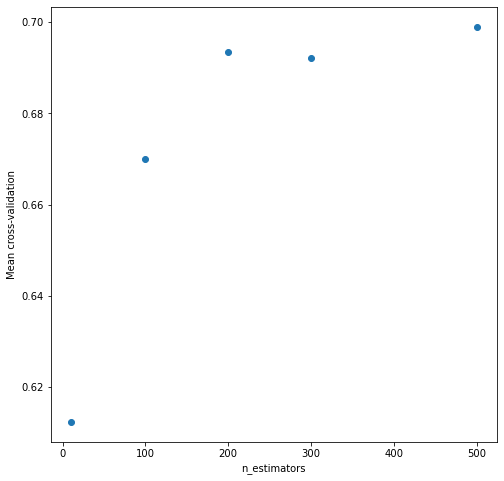

In [63]:
plt.figure(figsize= (8,8))
plt.scatter( n_estimators_value, auc_array_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Mean cross-validation')
plt.show()

### Thus, increasing in number of n_estimators have a good effect on prediction result. But it should be pointed out that the algorithm is becoming time-consuming with growth of n_estimators number.

### 3.2. Hyperparameter - max_depth

In [64]:
n_estimators_value = 100
max_depth_value = [2, 10 ,50 ,100, 1000]
min_samples_split_value = 2
auc_array_max_depth = []
for elem in max_depth_value:
    auc = cross_validation_RF(train, test, features_list, target_name, n_estimators_value, elem, min_samples_split_value)
    auc_array_max_depth.append(auc)

Mean auc for 5-fold: 0.8293312605638263
Mean auc for 5-fold: 0.8047661911593715
Mean auc for 5-fold: 0.6490658989057962
Mean auc for 5-fold: 0.6445273713533213
Mean auc for 5-fold: 0.6466954454469921


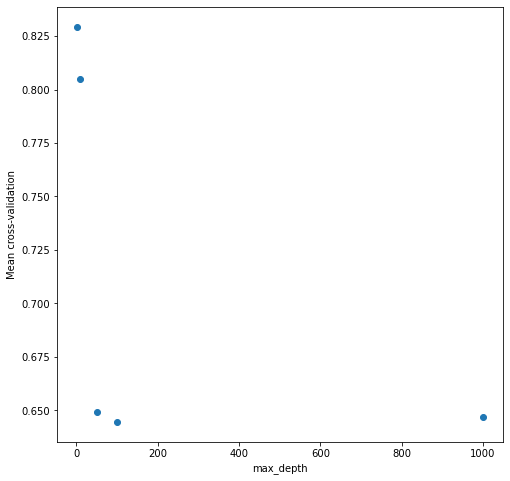

In [65]:
plt.figure(figsize= (8,8))
plt.scatter( max_depth_value, auc_array_max_depth)
plt.xlabel('max_depth')
plt.ylabel('Mean cross-validation')
plt.show()

### In our case big max_depth is dangerous. We get overfitted easily.

### 3.3.Hyperparameter - min_samples_split

In [66]:
n_estimators_value = 100
max_depth_value = 20
min_samples_split_value = [2, 10, 100, 1000, 5000]
auc_array_min_samples_split = []
for elem in min_samples_split_value:
    auc = cross_validation_RF(train, test, features_list, target_name, n_estimators_value, max_depth_value, elem)
    auc_array_min_samples_split.append(auc)

Mean auc for 5-fold: 0.6660290599722192
Mean auc for 5-fold: 0.7298463844115555
Mean auc for 5-fold: 0.81490129459623
Mean auc for 5-fold: 0.839027551263726
Mean auc for 5-fold: 0.8315435056610285


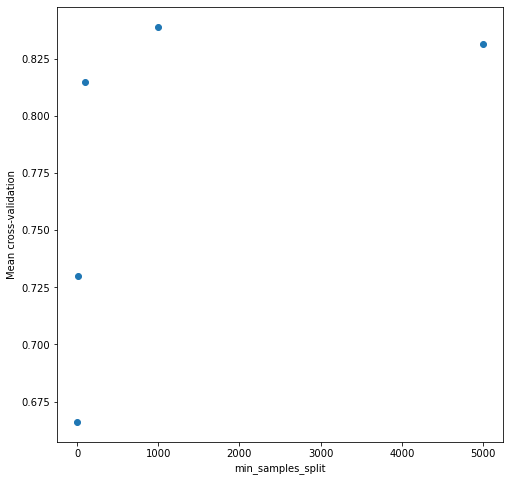

In [68]:
plt.figure(figsize= (8,8))
plt.scatter(min_samples_split_value, auc_array_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('Mean cross-validation')
plt.show()

### In this case, increasing of min_samples_split number results in increasing mean CV score but at point 5000 mean CV score starts to fall again, so we got optimal value somewhere between 1000 and 5000.

## Issue 4

### Q: Make submit for each algorithm: logistic regression, decision tree, and random forest. Which one showed the best result?

### I've got next results on Kaggle:

### Logistic regression: 0.86112
### Decision tree: 0.82611
### Random forest: 0.85783

### Logistic regression showed the best result.